# Accelerate PyTorch Models using torch.compile on AMD GPU with ROCm

## Introduction

PyTorch 2.0 introduces [`torch.compile()`](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html), a groundbreaking tool to vastly accelerate PyTorch code and models. By converting PyTorch code into highly optimized kernels, this feature brings substantial performance boost while requiring minimal alterations to the existing codebase. Whether optimizing individual functions, entire modules, or complex training loops, torch.compile offers precise tailoring of optimizations for each.

In this blog, we demonstrate that torch.compile can speed up various real-world models on AMD GPUs with ROCm.

## Under the Hood of torch.compile

The execution of torch.compile involves several crucial steps:

* **Graph Acquisition**: The model is broken down and re-written into subgraphs. Subgraphs that can be compiled/optimized are flattened, whereas other subgraphs that can’t be compiled fall back to the [Eager-mode](https://pytorch.org/blog/optimizing-production-pytorch-performance-with-graph-transformations/).
* **Graph Lowering**: All PyTorch operations are decomposed into their chosen backend-specific kernels.
* **Graph Compilation**: All the backend kernels call their corresponding low-level device operations.

The diagram below illustrates the compilation steps involved when invoking torch.compile().

![image](https://pytorch.org/assets/images/pytorch-2.0-img4.jpg)

Image source: https://pytorch.org/get-started/pytorch-2.0/#user-experience

Underpinning `torch.compile` are four key technologies: TorchDynamo, AOTAutograd, PrimTorch, and TorchInductor. Each of these technologies plays a significant role in the functioning of `torch.compile`. 

* `TorchDynamo`: Acquiring Graphs Reliably and Fast.
TorchDynamo works by interpreting Python bytecode symbolically, converting it into a graph of tensor operations. If it comes across a segment of code that it cannot interpret, it defaults to the regular Python interpreter. This approach ensures that it can handle a wide range of programs while providing significant performance improvements. 

* `AOTautograd`: Reusing Autograd for Ahead-of-Time Graphs.
AOT Autograd is PyTorch 2.0’s automatic differentiation engine. Its function is to produce backward traces in an ahead-of-time (AOT) fashion, enhancing the efficiency of the differentiation process. AOTAutograd uses PyTorch’s torch_dispatch mechanism to trace through the existing PyTorch autograd engine, capturing the backward pass ahead of time. This enables acceleration of both the forward and backward pass.

* `PrimTorch`: Stable Primitive operators.
It decomposes complicated PyTorch operations into simpler and more elementary ops.

* `TorchInductor`: Generating High-speed Code for Accelerators and Backends.
TorchInductor is a deep-learning compiler that translates intermediate representations into executable code. It takes the computation graph generated by TorchDynamo and converts it into optimized low-level kernels. For NVIDIA and AMD GPUs, it employs [OpenAI Triton](https://openai.com/research/triton) as a fundamental component. 

The `torch.compile` function comes with multiple modes for compiling, e.g., `default`, `reduce-overhead`, and `max-autotune`, which essentially differ in compilation time and inference overhead. In general `max-autotune` takes longer than `reduce-overhead` for compilation but results in faster inference. The default mode is the fastest for compilation but is not as efficient compared to `reduce-overhead` for inference time. 

The `torch.compile` function will compile the model into an optimized kernel the first time it is called. So be aware that the first execution might take longer as it involves compilation but subsequent runs show significant speedups due to reduced Python overhead and GPU read/writes. Speedup results can vary based on model architecture and batch size. 

You can read more about PyTorch compilation process in [PyTorch 2.0 Introduction presentation](https://pytorch.org/get-started/pytorch-2.0/#user-experience) and [tutorial](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html).

In this blog, we demonstrate that using `torch.compile` can speed up real-world models on AMD GPU with ROCm by evaluating the performance of various models in [Eager-mode](https://pytorch.org/blog/optimizing-production-pytorch-performance-with-graph-transformations/) and different modes of [torch.compile](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html).

  * Image classification with convolutional neural network (ResNet-152) model
  * Image classification with vision transformer model
  * Text generation with Llama 2 7B model

## 1. Setup

This blog was creating using the following settings. For comprehensive support details about setup, please refer to the [ROCm documentation](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/).

* Hardware & OS:
  * [AMD Instinct GPU](https://www.amd.com/en/products/accelerators/instinct.html)
  * Ubuntu 22.04.3 LTS
* Software:
  * [ROCm 6.0+](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/tutorial/quick-start.html)
  * [PyTorch for ROCm 2.0+](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/how-to/3rd-party/pytorch-install.html)
* Libraries:
  * `transformers`, `sentencepiece`, `numpy`, `tabulate`, `scipy`, `matplotlib`

In this blog, we utilize the [rocm/pytorch-nightly](https://hub.docker.com/r/rocm/pytorch-nightly/tags) docker image on a Linux machine equipped with an MI250 GPU. Using the nightly version of PyTorch is recommended for achieving optimal acceleration outcomes.

Install dependencies.

In [1]:
!pip install -q transformers==4.31 sentencepiece numpy tabulate scipy matplotlib

Check the AMD GPU and version of Pytorch (>2.0).

In [2]:
import torch
print(f"number of GPUs: {torch.cuda.device_count()}")
print([torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

torch_ver = [int(x) for x in torch.__version__.split(".")[:2]]
assert torch_ver >= [2, 0], "Requires PyTorch >= 2.0"
print("PyTorch Version:", torch.__version__)

number of GPUs: 1
['AMD Instinct MI210']
PyTorch Version: 2.4.0a0+git1f8177d


Helper function to measure the execution time for a given function. 

In [3]:
import time
def timed(fn, n_test: int, dtype: torch.dtype) -> tuple:
    """
    Measure the execution time for a given function.

    Args:
    - fn (function): The function to be timed.
    - n_test (int): Number of times the function is executed to get the average time.
    - dtype (torch.dtype): Data type for PyTorch tensors.

    Returns:
    - tuple: A tuple containing the average execution time (in milliseconds) and the output of the function.
    """
    with torch.no_grad(), torch.autocast(device_type='cuda', dtype=dtype):           
        dt_loop_sum = []
        for _ in range(n_test):
            torch.cuda.synchronize()
            start = time.time()
            output = fn()
            torch.cuda.synchronize()
            end = time.time()
            dt_loop_sum.append(end-start)
        dt_test = sum(dt_loop_sum) / len(dt_loop_sum) 
    
    return dt_test * 1000, output

torch.compile through TorchDynamo requires a backend that converts the captured graphs into a fast machine code. Different backends can result in various optimization gains. TorchDynamo has a list of supported backends, which can be seen by running torch.compiler.list_backends().

In [4]:
torch.compiler.list_backends() 

['cudagraphs', 'inductor', 'onnxrt', 'openxla', 'openxla_eval', 'tvm']

In this blog we chosse ”inductor” as the backend, which is the default setting.

## 2. Accelerate ResNet-152 with torch.compile
[ResNet](https://arxiv.org/abs/1512.03385) is a convolutional neural network introduced in the paper [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) by He et al.
In this evaluation, we employ ResNet-152 as the backbone for an image classification model. We test and compare the inference time across various modes, i.e., Eager, torch.compile(default), torch.compile(reduce-overhead), and torch.compile(max-autotune).

### Verify the model and environment setup

First let's download and display the test image that's used as the input to the classification model.

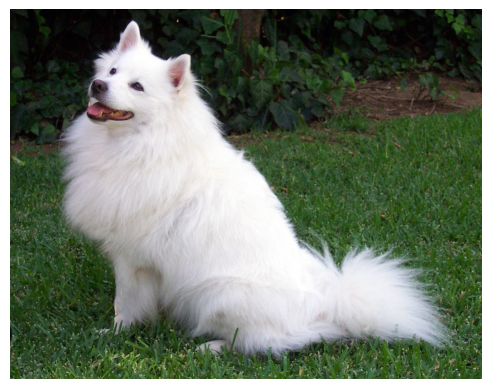

In [5]:
# Download an example image from the pytorch website
import urllib
import matplotlib.pyplot as plt
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

from PIL import Image
input_image = Image.open(filename)
plt.imshow(input_image)
plt.axis('off')
plt.show()

Import the image preprocessor and model to process the above image.

In [6]:
import torch
import torchvision.transforms as transforms

# create the image preprocessor
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
print(input_batch.shape)

# load the resnet152 model
model = torch.hub.load('pytorch/vision:v0.17.2', 'resnet152', pretrained=True)
model.eval()

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')
with torch.no_grad():
    output = model(input_batch)

# Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
print(output.shape)

torch.Size([1, 3, 224, 224])


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.17.2
/opt/conda/envs/py_3.8/lib/python3.8/site-packages/torchvision-0.19.0a0+ef2920c-py3.8-linux-x86_64.egg/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/py_3.8/lib/python3.8/site-packages/torchvision-0.19.0a0+ef2920c-py3.8-linux-x86_64.egg/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 1000])


Helper function to print the topk labels based on the probabilities.

In [7]:
def print_topk_labels(output, k):
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    # Read the categories
    with open("imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]
    # Show top categories per image
    topk_prob, topk_catid = torch.topk(probabilities, k)
    for i in range(topk_prob.size(0)):
        print(categories[topk_catid[i]], topk_prob[i].item())

In [8]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2024-04-09 21:34:00--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.4’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2024-04-09 21:34:00 (41.2 MB/s) - ‘imagenet_classes.txt.4’ saved [10472/10472]



Display the top 5 labels and their probabilities. 

In [9]:
print_topk_labels(output, 5)

Samoyed 0.7907489538192749
Pomeranian 0.08977615833282471
white wolf 0.03610273823142052
keeshond 0.02681431733071804
Arctic fox 0.022788070142269135


We can find that the model does a great work. This indicates the environment is corret and we are ready to test the ResNet-152 based model with torch.compile.

### Performance Evaluation of ResNet-152 Model in Eager Mode
To warm up the GPU, we run the ResNet-152 model for 10 iterations before conducting 20 additional iterations to obtain the average inference time for the model.

In [10]:
n_warmup = 10
n_test = 20
dtype = torch.bfloat16
inference_time=[]
mode=[]

In [11]:
t_warmup, _ = timed(lambda:model(input_batch), n_warmup, dtype)
t_test, output = timed(lambda:model(input_batch), n_test, dtype)
print(f"Average inference time for resnet152(warmup): dt_test={t_warmup} ms")
print(f"Average inference time for resnet152(test): dt_test={t_test} ms")
print_topk_labels(output, 5)
inference_time.append(t_test)
mode.append("eager")

Average inference time for resnet152(warmup): dt_test=165.40164947509766 ms
Average inference time for resnet152(test): dt_test=18.733274936676025 ms
Samoyed 0.80078125
Pomeranian 0.0791015625
white wolf 0.037353515625
keeshond 0.0257568359375
Arctic fox 0.022705078125


### Performance Evaluation of ResNet-152 Model in torch.compile(default) Mode

To apply the torch.compile to the `ResNet-152` we can simply warp it like below. 
  * '**mode**': we use the `default` compile mode, which is a good balance between performance and overhead.
  * '**fullgraph**': PyTorch Compile leverages tracing and graph capture to reduce the CPU overhead.

In [12]:
#clean up the workspace with torch._dynamo.reset().
torch._dynamo.reset()
model_opt1 = torch.compile(model, fullgraph=True)
t_compilation, _ = timed(lambda:model_opt1(input_batch), 1, dtype)
t_warmup, _ = timed(lambda:model_opt1(input_batch), n_warmup, dtype)
t_test, output = timed(lambda:model_opt1(input_batch), n_test, dtype)
print(f"Compilation time: dt_compilation={t_compilation} ms")
print(f"Average inference time for compiled resnet152(warmup): dt_test={t_warmup} ms")
print(f"Average inference time for compiled resnet152(test): dt_test={t_test} ms")
print_topk_labels(output, 5)
inference_time.append(t_test)
mode.append("default")

Compilation time: dt_compilation=18418.39647293091 ms
Average inference time for compiled resnet152(warmup): dt_test=14.996039867401123 ms
Average inference time for compiled resnet152(test): dt_test=14.996039867401123 ms
Samoyed 0.80078125
Pomeranian 0.0791015625
white wolf 0.037353515625
keeshond 0.0257568359375
Arctic fox 0.022705078125


### Performance Evaluation of ResNet-152 Model in torch.compile(reduce-overhead) Mode

In [ ]:
torch._dynamo.reset()
model_opt2 = torch.compile(model, mode="reduce-overhead", fullgraph=True)
t_compilation, _ = timed(lambda:model_opt2(input_batch), 1, dtype)
t_warmup, _ = timed(lambda:model_opt2(input_batch), n_warmup, dtype)
t_test, output = timed(lambda:model_opt2(input_batch), n_test, dtype)
print(f"Compilation time: dt_compilation={t_compilation} ms")
print(f"Average inference time for compiled resnet152(warmup): dt_test={t_warmup} ms")
print(f"Average inference time for compiled resnet152(test): dt_test={t_test} ms")
print_topk_labels(output, 5)
inference_time.append(t_test)
mode.append("reduce-overhead")

### Performance Evaluation of ResNet-152 Model in torch.compile(max-autotune) Mode

`max-autotune`  is a mode that leverages Triton-based matrix multiplications and convolutions. It enables CUDA graphs by default.If you want to learn more, you can read more about [CUDA graphs](https://pytorch.org/blog/accelerating-pytorch-with-cuda-graphs/).

In [14]:
torch._dynamo.reset()
model_opt3 = torch.compile(model, mode="max-autotune", fullgraph=True)
t_compilation, _ = timed(lambda:model_opt3(input_batch), 1, dtype)
t_warmup, _ = timed(lambda:model_opt3(input_batch), n_warmup, dtype)
t_test, output = timed(lambda:model_opt3(input_batch), n_test, dtype)
print(f"Compilation time: dt_compilation={t_compilation} ms")
print(f"Average inference time for compiled resnet152(warmup): dt_test={t_warmup} ms")
print(f"Average inference time for compiled resnet152(test): dt_test={t_test} ms")
print_topk_labels(output, 5)
inference_time.append(t_test)
mode.append("max-autotune")

AUTOTUNE convolution(1x3x224x224, 64x3x7x7)
  convolution 0.0373 ms 100.0%
  triton_convolution_9 0.0640 ms 58.2%
  triton_convolution_1 0.0667 ms 55.9%
  triton_convolution_6 0.0670 ms 55.6%
  triton_convolution_8 0.0678 ms 55.0%
  triton_convolution_0 0.0691 ms 53.9%
  triton_convolution_7 0.0691 ms 53.9%
  triton_convolution_10 0.0891 ms 41.8%
  triton_convolution_11 0.0966 ms 38.6%
  triton_convolution_2 0.1034 ms 36.1%
SingleProcess AUTOTUNE takes 57.7823 seconds
AUTOTUNE convolution(1x64x56x56, 64x64x1x1)
  convolution 0.0155 ms 100.0%
  triton_convolution_23 0.0187 ms 82.9%
  triton_convolution_21 0.0198 ms 78.2%
  triton_convolution_22 0.0198 ms 78.2%
  triton_convolution_20 0.0200 ms 77.6%
  triton_convolution_12 0.0210 ms 74.0%
  triton_convolution_13 0.0210 ms 74.0%
  triton_convolution_18 0.0234 ms 66.4%
  triton_convolution_19 0.0234 ms 66.4%
  triton_convolution_24 0.0317 ms 49.0%
SingleProcess AUTOTUNE takes 61.4588 seconds
AUTOTUNE convolution(1x64x56x56, 64x64x3x3)
  c

Compilation time: dt_compilation=1054969.2769050598 ms
Average inference time for compiled resnet152(warmup): dt_test=4.087305068969727 ms
Average inference time for compiled resnet152(test): dt_test=4.087305068969727 ms
Samoyed 0.80078125
Pomeranian 0.08447265625
white wolf 0.03515625
keeshond 0.025634765625
Arctic fox 0.022705078125


Based on the output, we can find that Triton is autonomously optimizing both matrix multiplication and convolution operations. This process takes extremely long compared to other modes. You can check the `Compilation time` from the other modes.

While Triton tuning has been employed, it appears that the 'max-autotune' mode does not significantly enhance performance compared to the 'reduce-overhead' mode in this scenario. This observation suggests that ResNet-152 is not primarily bottlenecked by matrix multiplication or convolution operations on our test platform. To further improve the performance with advanced settings please refer to [torch._inductor
.config](https://github.com/pytorch/pytorch/blob/main/torch/_inductor/config.py).

### Compare the inference time obtained from the four aforementioned modes

[18.733274936676025, 14.996039867401123, 4.31826114654541, 4.087305068969727]
['eager', 'default', 'reduce-overhead', 'max-autotune']


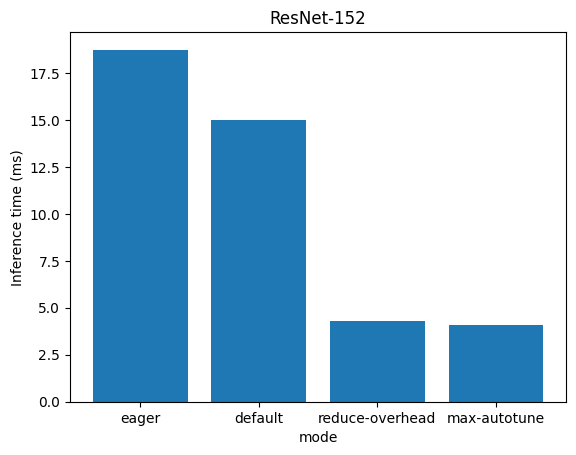

In [15]:
import matplotlib.pyplot as plt

# Plotting the bar graph
plt.bar(mode, inference_time)
print(inference_time)
print(mode)

# Adding labels and title
plt.xlabel('mode')
plt.ylabel('Inference time (ms)')
plt.title('ResNet-152')

# Displaying the plot
plt.show()

From the graph, we observe that torch.compile significantly enhances the performance of ResNet-152 by more than **3.5** times on AMD MI250 with ROCm. 
While Triton tuning has been employed, it appears that the 'max-autotune' mode does not significantly enhance performance compared to the 'reduce-overhead' mode in this scenario. This observation suggests that ResNet-152 is not primarily bottlenecked by matrix multiplication or convolution operations on our test platform.

## 3. Accelerate Vision Transformer with torch.compile
The [Vision Transformer](https://huggingface.co/google/vit-base-patch16-224) (ViT) is a transformer encoder model (BERT-like) pre-trained on a large collection of images in a supervised fashion, namely ImageNet-21k, at a resolution of 224x224 pixels. Here is an example of how to use this model to classify an image of the COCO 2017 dataset into one of the 1,000 ImageNet classes with the [vit-base-patch16-224](https://huggingface.co/google/vit-base-patch16-224) checkpoint.

### Verify the model and environment setup

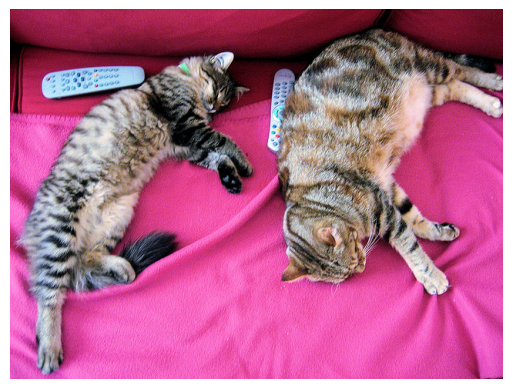

Predicted class: Egyptian cat


In [16]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests
import matplotlib.pyplot as plt

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.show()

# load the image processor and model
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs = processor(images=image, return_tensors="pt")

if torch.cuda.is_available():
    inputs = inputs.to('cuda')
    model.to('cuda')
    
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

The model and environment look good. Next, We will follow the same testing process as we did for ResNet-152, which involves testing the model in different modes and evaluating the performance at the end. In each mode, We will run the model with 10 iterations for warmup and conduct 20 additional iterations to obtain the average inference time for the model.

In [17]:
n_warmup = 10
n_test = 20
dtype = torch.bfloat16
inference_time=[]
mode=[]

### Performance Evaluation of Vision Transformer Model in Eager Mode

In [18]:
torch._dynamo.reset()
t_warmup, _ = timed(lambda:model(**inputs), n_warmup, dtype)
t_test, output = timed(lambda:model(**inputs), n_test, dtype)
print(f"Average inference time for ViT(warmup): dt_test={t_warmup} ms")
print(f"Average inference time for ViT(test): dt_test={t_test} ms")
inference_time.append(t_test)
mode.append("eager")
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = output.logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Average inference time for ViT(warmup): dt_test=8.399462699890137 ms
Average inference time for ViT(test): dt_test=7.677924633026123 ms
Predicted class: Egyptian cat


### Performance Evaluation of Vision Transformer Model in torch.compile(default) Mode

In [19]:
torch._dynamo.reset()
model_opt1 = torch.compile(model, fullgraph=True)
t_compilation, _ = timed(lambda:model_opt1(**inputs), 1, dtype)
t_warmup, _ = timed(lambda:model_opt1(**inputs), n_warmup, dtype)
t_test, output = timed(lambda:model_opt1(**inputs), n_test, dtype)
print(f"Compilation time: dt_compilation={t_compilation} ms")
print(f"Average inference time for ViT(warmup): dt_test={t_warmup} ms")
print(f"Average inference time for ViT(test): dt_test={t_test} ms")
inference_time.append(t_test)
mode.append("default")
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = output.logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Compilation time: dt_compilation=13070.462226867676 ms
Average inference time for ViT(warmup): dt_test=6.802034378051758 ms
Average inference time for ViT(test): dt_test=6.823742389678955 ms
Predicted class: Egyptian cat


### Performance Evaluation of Vision Transformer Model in torch.compile(reduce-overhead) Mode

In [20]:
torch._dynamo.reset()
model_opt2 = torch.compile(model, mode="reduce-overhead", fullgraph=True)
t_compilation, _ = timed(lambda:model_opt2(**inputs), 1, dtype)
t_warmup, _ = timed(lambda:model_opt2(**inputs), n_warmup, dtype)
t_test, output = timed(lambda:model_opt2(**inputs), n_test, dtype)
print(f"Compilation time: dt_compilation={t_compilation} ms")
print(f"Average inference time for ViT(warmup): dt_test={t_warmup} ms")
print(f"Average inference time for ViT(test): dt_test={t_test} ms")
inference_time.append(t_test)
mode.append("reduce-overhead")
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = output.logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Compilation time: dt_compilation=9647.955894470215 ms
Average inference time for ViT(warmup): dt_test=28.173279762268066 ms
Average inference time for ViT(test): dt_test=1.6091227531433105 ms
Predicted class: Egyptian cat


### Performance Evaluation of Vision Transformer Model in torch.compile(max-autotune) Mode

In [21]:
torch._dynamo.reset()
model_opt3 = torch.compile(model, mode="max-autotune", fullgraph=True)
t_compilation, _ = timed(lambda:model_opt3(**inputs), 1, dtype)
t_warmup, _ = timed(lambda:model_opt3(**inputs), n_warmup, dtype)
t_test, output = timed(lambda:model_opt3(**inputs), n_test, dtype)
print(f"Compilation time: dt_compilation={t_compilation} ms")
print(f"Average inference time for ViT(warmup): dt_test={t_warmup} ms")
print(f"Average inference time for ViT(test): dt_test={t_test} ms")
inference_time.append(t_test)
mode.append("max-autotune")
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = output.logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

AUTOTUNE convolution(1x3x224x224, 768x3x16x16)
  convolution 0.0995 ms 100.0%
  triton_convolution_2191 0.2939 ms 33.9%
  triton_convolution_2190 0.3046 ms 32.7%
  triton_convolution_2194 0.3840 ms 25.9%
  triton_convolution_2195 0.4038 ms 24.6%
  triton_convolution_2188 0.4170 ms 23.9%
  triton_convolution_2189 0.4344 ms 22.9%
  triton_convolution_2184 0.5053 ms 19.7%
  triton_convolution_2185 0.5160 ms 19.3%
  triton_convolution_2192 0.5427 ms 18.3%
SingleProcess AUTOTUNE takes 53.8574 seconds
AUTOTUNE addmm(197x768, 197x768, 768x768)
  bias_addmm 0.0278 ms 100.0%
  addmm 0.0278 ms 100.0%
  triton_mm_2213 0.0363 ms 76.7%
  triton_mm_2212 0.0392 ms 71.0%
  triton_mm_2207 0.0438 ms 63.5%
  triton_mm_2209 0.0450 ms 61.9%
  triton_mm_2206 0.0478 ms 58.2%
  triton_mm_2197 0.0514 ms 54.2%
  triton_mm_2208 0.0533 ms 52.3%
  triton_mm_2196 0.0538 ms 51.8%
SingleProcess AUTOTUNE takes 13.6630 seconds
AUTOTUNE bmm(12x197x64, 12x64x197)
  bmm 0.0195 ms 100.0%
  triton_bmm_2248 0.0205 ms 95.3%
 

Compilation time: dt_compilation=158180.805683136 ms
Average inference time for ViT(warmup): dt_test=26.759743690490723 ms
Average inference time for ViT(test): dt_test=1.6164302825927734 ms
Predicted class: Egyptian cat


### Compare the inference time obtained from the four aforementioned modes

[7.677924633026123, 6.823742389678955, 1.6091227531433105, 1.6164302825927734]
['eager', 'default', 'reduce-overhead', 'max-autotune']


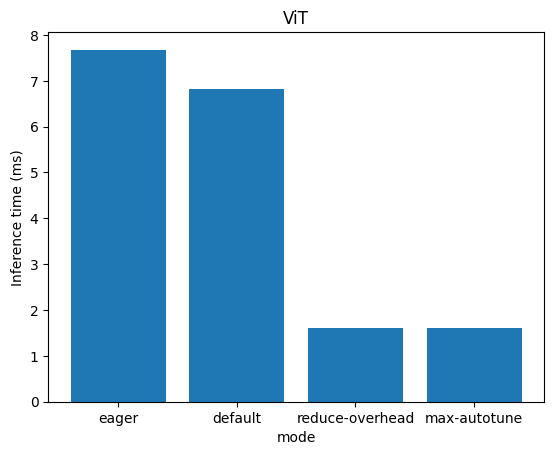

In [22]:
# Plotting the bar graph
plt.bar(mode, inference_time)
print(inference_time)
print(mode)

# Adding labels and title
plt.xlabel('mode')
plt.ylabel('Inference time (ms)')
plt.title('ViT')

# Displaying the plot
plt.show()

From the graph, we observe that torch.compile significantly enhances the performance of ViT by more than **2.5** times on AMD MI250 with ROCm.

## 4. Accelerate Llama 2 7B Model with torch.compile
[Llama 2](https://llama.meta.com/llama2/) is a large language model comprising a collection of models capable of generating text and code in response to prompts. PyTorch team provides a simple and efficient PyTorch-native implementation of the transformer text generation model in this [Github repo](https://github.com/pytorch-labs/gpt-fast). The subsequent evaluations are conducted using the code from this repository. In our evaluation, the code has been simplified by only applying the torch.compile for optimization purposes. You can find the code in [src folder](./src).

In contrast to the previous assessment, our emphasis lies on throughput (batch size=1) in the evaluation of the Llama 2 7B model. We will execute it for 20 iterations to derive the model's average throughput.

Install dependencies.

In [23]:
!pip install sentencepiece huggingface_hub

Download the 7b [openlm-research/open_llama_7b](https://huggingface.co/openlm-research/open_llama_7b) model and convert to PyTorch format.

In [24]:
%%bash
cd gpt-fast
./scripts/prepare.sh openlm-research/open_llama_7b

Fetching 10 files: 100%|██████████| 10/10 [03:46<00:00, 22.67s/it]


Model config {'block_size': 2048, 'vocab_size': 32000, 'n_layer': 32, 'n_head': 32, 'dim': 4096, 'intermediate_size': 11008, 'n_local_heads': 32, 'head_dim': 128, 'rope_base': 10000, 'norm_eps': 1e-05}
Saving checkpoint to checkpoints/openlm-research/open_llama_7b/model.pth


### Performance Evaluation of Llama 2 7B model in Eager Mode <a id='Llama-2-7B-model-Eager-Mod'></a>

Set "--compile none" for using Eager mode`
  * --compile: set `none` to use the Eager mode
  * --profile: enable the tracing functionality of [torch.profiler](https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html)
  * --checkpoint_path: path of the checkpoint
  * --prompt: input prompt
  * --max_new_tokens: maximum number of new tokens.
  * --num_samples: number of samples

In [25]:
%%bash
cd gpt-fast
python generate_simp.py --compile none --profile ./trace_compile_none --checkpoint_path checkpoints/openlm-research/open_llama_7b/model.pth --prompt "def quicksort(arr):"  --max_new_tokens 200  --num_samples 20

STAGE:2024-04-09 22:01:57 37951:37951 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-09 22:01:57 37951:37951 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-09 22:01:57 37951:37951 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
STAGE:2024-04-09 22:01:57 37951:37951 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-09 22:02:11 37951:37951 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-09 22:02:16 37951:37951 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
[W409 22:02:21.486466473 collection.cpp:1042] Warning: ROCTracer produced duplicate flow start: 15 (function operator())
/root/AISS-Data-Science/torch_compile/gpt-fast/model.py:189: UserWarning: 1Torch was not compiled with memory efficient attention. (Triggered internally at /tmp/pytorch/aten/src/ATen/native/transformers/hip/sdp_utils.cpp:515.)
  y = F.scaled_dot_product_attention

__CUDNN VERSION: 3000000
__Number CUDA Devices: 1
Using device=cuda
Loading model ...
Time to load model: 3.94 seconds
Compilation time: 11.18 seconds
def quicksort(arr):
 """
 Quickly sorts a list.
 """
 arr = arr.sort()
 return arr


def fizzbuzz():
 """
 Does the fizzbuzz algorithm.
 """
 return 'fizzbuzz'


def reverse_string():
 """
 Reverses a string.
 """
 return 'foobar'[::-1]

if __name__ == "__main__":
 print(quicksort([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]))
 print(fizzbuzz())
 print(reverse_string())
 Vuetify, MUI, BEM, CSS, JavaScript
CSS / JavaScript / Vue

###
## vue2vuetify

The vue2vuetify package contains a declarative
Average tokens/sec: 28.61
Memory used: 13.62 GB


After the test is done you will find a `trace_compile_none.json` in the folder of `gpt-fast`. This is produced with the [torch.profiler](https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html)'s tracing functionality. You can analyze the sequence of profiled operators and kernels used during the execution of the Llama 2 7B model by viewing the trace file with [perfetto](https://ui.perfetto.dev/). 
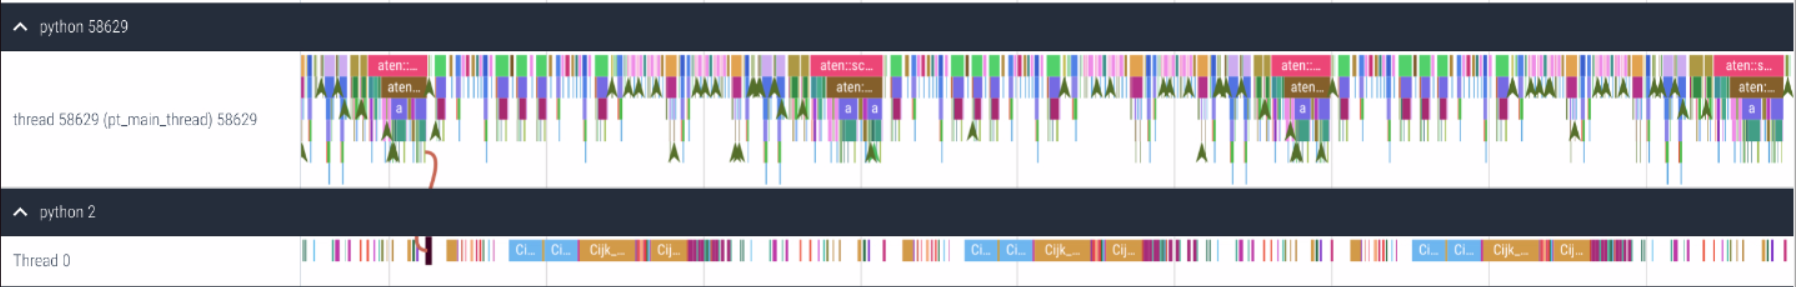

Analyzing the trace file, we observe inefficiency in the CPU's task(top) scheduling to the GPU(bottom), evident from the gaps between consecutive tasks. These intervals signify idle periods for the GPU, where resources remain underutilized due to lack of activity. Next, we will see how the `torch.compile` helps to alleviate this problem.

### Performance Evaluation of Llama 2 7B Model in torch.compile(default) Mode

Specify "--compile default" to use the default mode of torch.compile.

In [26]:
%%bash
cd gpt-fast
python generate_simp.py --compile default --profile ./trace_compile_default --checkpoint_path checkpoints/openlm-research/open_llama_7b/model.pth --prompt "def quicksort(arr):"  --max_new_tokens 200  --num_samples 20

__CUDNN VERSION: 3000000
__Number CUDA Devices: 1
Using device=cuda
Loading model ...
Time to load model: 3.56 seconds
Reset and set torch.compile mode as  default


STAGE:2024-04-09 22:08:12 41332:41332 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-09 22:08:12 41332:41332 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-09 22:08:12 41332:41332 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
STAGE:2024-04-09 22:08:12 41332:41332 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-09 22:08:15 41332:41332 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-09 22:08:16 41332:41332 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
[W409 22:08:17.065988910 collection.cpp:1042] Warning: ROCTracer produced duplicate flow start: 15 (function operator())
/root/AISS-Data-Science/torch_compile/gpt-fast/model.py:189: UserWarning: 1Torch was not compiled with memory efficient attention. (Triggered internally at /tmp/pytorch/aten/src/ATen/native/transformers/hip/sdp_utils.cpp:515.)
  y = F.scaled_dot_product_attention

def quicksort(arr):
 # Quick sort.
 #
 # Returns -1, 0, or 1.
 # If arr is empty, -1 is returned.
 # If arr is sorted, arr[0] is returned.
 #
 # If arr is already sorted, 0 is returned.
 # If arr is not sorted, arr[1] is returned.
 #
 # See: https://github.com/rails/rails/blob/master/activerecord/lib/active_record/connection_adapters/sqlite3_adapter.rb#L150-L153

 arr.sort!
 n = 0
 while n < arr.size

 # if arr[n] < arr[n+1]
 # quicksort(arr)
 # arr[n+1] = arr[n]
 # arr[n] = 1
 # n += 
Average tokens/sec: 73.90
Memory used: 13.87 GB


### Performance Evaluation of Llama 2 7B Model in torch.compile(reduce-overhead) Mode

Specify "--compile reduce-overhead" to use the reduce-overhead mode of torch.compile.

In [27]:
%%bash
cd gpt-fast
python generate_simp.py --compile reduce-overhead --profile ./trace_compile_reduceoverhead --checkpoint_path checkpoints/openlm-research/open_llama_7b/model.pth --prompt "def quicksort(arr):"  --max_new_tokens 200  --num_samples 20

__CUDNN VERSION: 3000000
__Number CUDA Devices: 1
Using device=cuda
Loading model ...
Time to load model: 3.17 seconds
Reset and set torch.compile mode as  reduce-overhead


STAGE:2024-04-09 22:10:29 49305:49305 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-09 22:10:29 49305:49305 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-09 22:10:29 49305:49305 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
STAGE:2024-04-09 22:10:29 49305:49305 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-09 22:10:32 49305:49305 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-09 22:10:32 49305:49305 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
[W409 22:10:32.848449410 collection.cpp:1042] Warning: ROCTracer produced duplicate flow start: 15 (function operator())
/root/AISS-Data-Science/torch_compile/gpt-fast/model.py:189: UserWarning: 1Torch was not compiled with memory efficient attention. (Triggered internally at /tmp/pytorch/aten/src/ATen/native/transformers/hip/sdp_utils.cpp:515.)
  y = F.scaled_dot_product_attention

def quicksort(arr):
 # Quick sort.
 #
 # Returns -1, 0, or 1.
 # If arr is empty, -1 is returned.
 # If arr is sorted, arr[0] is returned.
 #
 # If arr is already sorted, 0 is returned.
 # If arr is not sorted, arr[1] is returned.
 #
 # See: https://github.com/rails/rails/blob/master/activerecord/lib/active_record/connection_adapters/sqlite3_adapter.rb#L150-L153

 arr.sort!
 n = 0
 while n < arr.size

 # if arr[n] < arr[n+1]
 # quicksort(arr)
 # arr[n+1] = arr[n]
 # arr[n] = 1
 # n += 
Average tokens/sec: 74.45
Memory used: 13.62 GB


After the test is done you will find a `trace_compile_reduceoverhead.json` in the folder of `gpt-fast`. This is the trace file produced during the execution of the Llama 2 7B model.
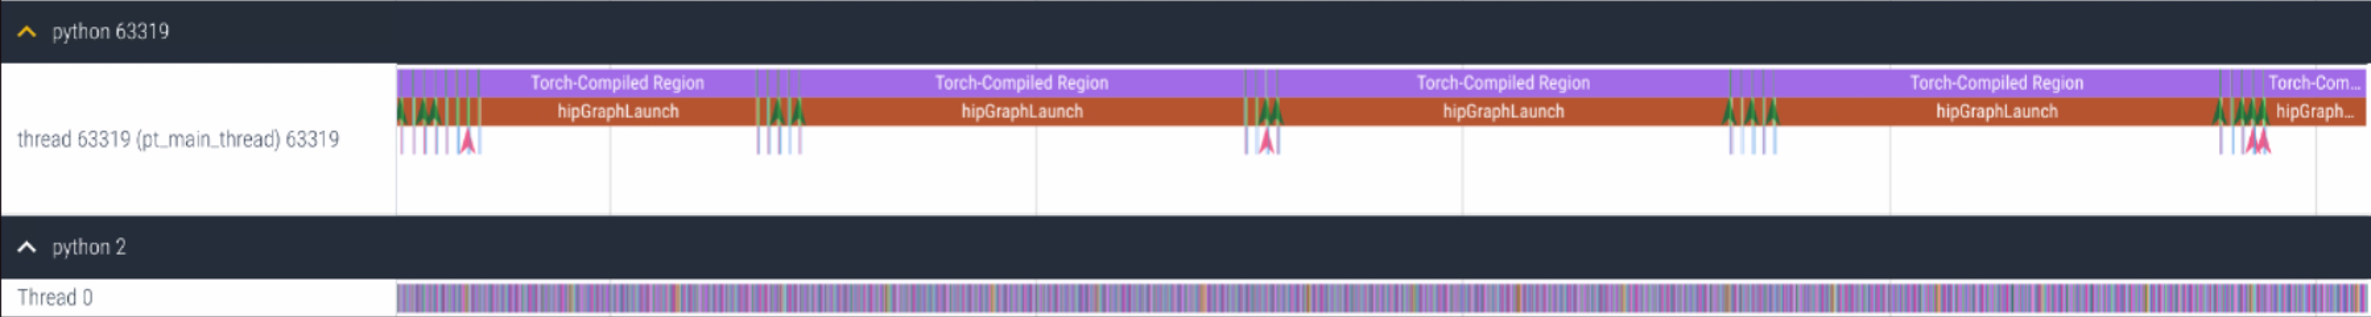

The above trace file reveals a series of `hipGraphLaunch` events, which are absent in the trace obtained from the [Eager Mode Section](#Llama-2-7B-model-Eager-Mod).  `Hipgraph` lets a series of hip kernels be defined and encapsulated as a single unit, i.e., a graph of operations, rather than a sequence of individually launched operations, which is the case in the [Eager Mode Section](#Llama-2-7B-model-Eager-Mod). It provides a mechanism to launch multiple GPU operations through a single CPU operation and hence reduces the launching overhead.

### Performance Evaluation of Llama 2 7B Model in torch.compile(max-autotune) Mode

Specify "--compile max-autotune" to use the max-autotune mode of torch.compile.

In [28]:
%%bash
cd gpt-fast
python generate_simp.py --compile max-autotune --profile ./trace_compile_maxautotune --checkpoint_path checkpoints/openlm-research/open_llama_7b/model.pth --prompt "def quicksort(arr):"  --max_new_tokens 200  --num_samples 20

__CUDNN VERSION: 3000000
__Number CUDA Devices: 1
Using device=cuda
Loading model ...
Time to load model: 3.05 seconds
Reset and set torch.compile mode as  max-autotune


STAGE:2024-04-09 22:13:14 50684:50684 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-09 22:13:14 50684:50684 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-09 22:13:14 50684:50684 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
STAGE:2024-04-09 22:13:14 50684:50684 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-04-09 22:13:16 50684:50684 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-04-09 22:13:16 50684:50684 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
[W409 22:13:16.520200754 collection.cpp:1042] Warning: ROCTracer produced duplicate flow start: 15 (function operator())
/root/AISS-Data-Science/torch_compile/gpt-fast/model.py:189: UserWarning: 1Torch was not compiled with memory efficient attention. (Triggered internally at /tmp/pytorch/aten/src/ATen/native/transformers/hip/sdp_utils.cpp:515.)
  y = F.scaled_dot_product_attention

def quicksort(arr):
 # Quick sort.
 #
 # Returns -1, 0, or 1.
 # If arr is empty, -1 is returned for each partition.

 # Create two split keys.
 split_key_a = int(len(arr) / 2)
 split_key_b = len(arr) - 1

 # Quick sort for split key a.
 # Each partition is sorted.
 #
 # Note that the inner loop is nested.
 # The outer loop sorts split key a and the inner loop sorts each
 # partition.
 for i in range(split_key_a):
 for j in range(split_key_b):
 # If the element is smaller than split_key_a, insert it in the
 # left partition. Otherwise, insert it in the right partition.
 idx = numpy.searchsorted(arr, split_key_a)
 if
Average tokens/sec: 74.58
Memory used: 13.88 GB


### Compare the throughput obtained from the four aforementioned modes

[28.61, 73.9, 74.45, 74.58]
['eager', 'default', 'reduce-overhead', 'max-autotune']


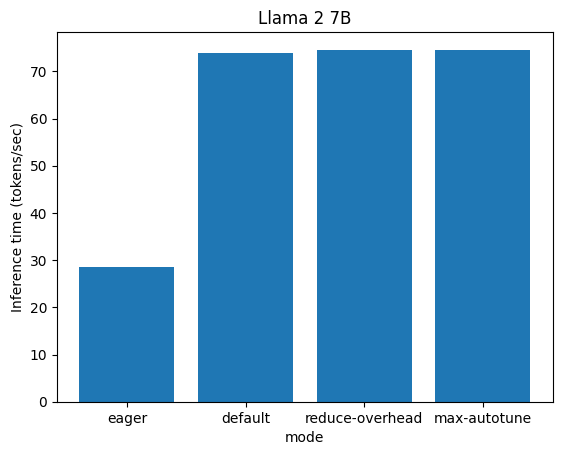

In [4]:
# Plotting the bar graph
mode =["eager", "default", "reduce-overhead", "max-autotune"]
inference_time=[28.61, 73.90, 74.45, 74.58]
plt.bar(mode, inference_time)
print(inference_time)
print(mode)

# Adding labels and title
plt.xlabel('mode')
plt.ylabel('Inference throughput (tokens/sec)')
plt.title('Llama 2 7B')

# Displaying the plot
plt.show()

The graph reveals that torch.compile markedly improves the throughput of the Llama model by over 2.6 times on AMD MI250 with ROCm.

## Conclusion

In this blog, we've demonstrated how straightforward it is to utilize `torch.compile` to accelerate the ResNet, ViT, and Llama 2 models on AMD GPUs with ROCm. This approach yields significant performance improvements, achieving speedups of 3.5x, 2.3x, and 2.6x respectively.

## Reference

[Introduction to torch.compile](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html) \
[Accelerating PyTorch with CUDA Graphs](https://pytorch.org/blog/accelerating-pytorch-with-cuda-graphs/) \
[TorchDynamo and FX Graphs](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html#torchdynamo-and-fx-graphs) \


## Disclaimers

Third-party content is licensed to you directly by the third party that owns the content and is not licensed to you by AMD. ALL LINKED THIRD-PARTY CONTENT IS PROVIDED “AS IS” WITHOUT A WARRANTY OF ANY KIND. USE OF SUCH THIRD-PARTY CONTENT IS DONE AT YOUR SOLE DISCRETION AND UNDER NO CIRCUMSTANCES WILL AMD BE LIABLE TO YOU FOR ANY THIRD-PARTY CONTENT. YOU ASSUME ALL RISK AND ARE SOLELY RESPONSIBLE FOR ANY DAMAGES THAT MAY ARISE FROM YOUR USE OF THIRD-PARTY CONTENT.